
# Generate smooth day01_prices_weather.csv

Creates a **single day** (96 × 15‑min) dataset with:
- Outdoor temperature as a smooth sine wave.
- Electricity price with a **duck curve** (morning + evening peaks, cheap mid‑day).

Saves `day01_prices_weather.csv` with columns: `t,dt_h,t_out_c,price_eur_per_kwh`.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
dt_h = 0.25          # hours per step
T = int(24/dt_h)     # steps per day

# Temperature (°C): hot summer day
t_mean = 24.0        # daily average
t_amp = 7.0          # amplitude (night ~17°C, peak ~31°C)
t_warmest_hour = 12  # warmest time of day (~15:00)

# Price (€/kWh) -- duck curve (UNCHANGED)
base_price = 0.16
morning_peak_eur = 0.22
evening_peak_eur = 0.33
midday_valley_eur = 0.08

sigma_morning_h = 1.6
sigma_evening_h = 2.2
sigma_midday_h  = 3.0

# Optional jitter (0 = perfectly smooth)
temp_jitter_std = 0.0
price_jitter_std = 0.0

# Solar generation curve (ideal bell curve peaking at 13:00)
solar_peak_hour = 13.0
solar_sigma_h = 2.5  # Spread of the solar generation
solar_max = 1.0      # Max output (normalized or in kW/kWp)

solar_gen = solar_max * gauss(hours, solar_peak_hour, solar_sigma_h)
df["solar_gen_kw_per_kwp"] = np.round(solar_gen, 3)

# Define a comfort temperature setpoint (for HVAC control etc.)
comfort_setpoint = 22.0  # °C
comfort_band = (21.0, 23.0)  # °C range considered comfortable

# Work hours: 9:00 to 17:00
work_start, work_end = 9.0, 17.0
in_work_hours = (hours >= work_start) & (hours <= work_end)
df["in_work_hours"] = in_work_hours.astype(int)
df["comfort_setpoint_c"] = np.where(in_work_hours, comfort_setpoint, np.nan)


# Output path (writes next to this notebook by default)
out_csv = "day01_prices_weather.csv"


In [38]:
# --- Generate ---
t = np.arange(T)
hours = t * dt_h

# Temperature sine wave (summer profile ONLY changed)
t_out = t_mean + t_amp * np.sin(2*np.pi*(hours - t_warmest_hour)/24.0)
if temp_jitter_std > 0:
    t_out = t_out + np.random.default_rng(0).normal(0, temp_jitter_std, size=T)

# Price duck curve: base + morning peak + evening peak - midday valley (UNCHANGED)
def gauss(x, mu, sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)

price = (base_price
         + morning_peak_eur * gauss(hours, 8.0, sigma_morning_h)
         + evening_peak_eur * gauss(hours, 18.5, sigma_evening_h)
         - midday_valley_eur * gauss(hours, 13.0, sigma_midday_h))

if price_jitter_std > 0:
    price = price + np.random.default_rng(1).normal(0, price_jitter_std, size=T)

price = np.clip(price, 0.05, None)

df = pd.DataFrame({
    "t": t.astype(int),
    "dt_h": np.full(T, dt_h, dtype=float),
    "t_out_c": np.round(t_out, 2),
    "price_eur_per_kwh": np.round(price, 3),
})
df.head()

,t,dt_h,t_out_c,price_eur_per_kwh
0,0,0.25,24.00,0.16
1,1,0.25,23.54,0.16
2,2,0.25,23.09,0.16
3,3,0.25,22.63,0.16
4,4,0.25,22.19,0.16


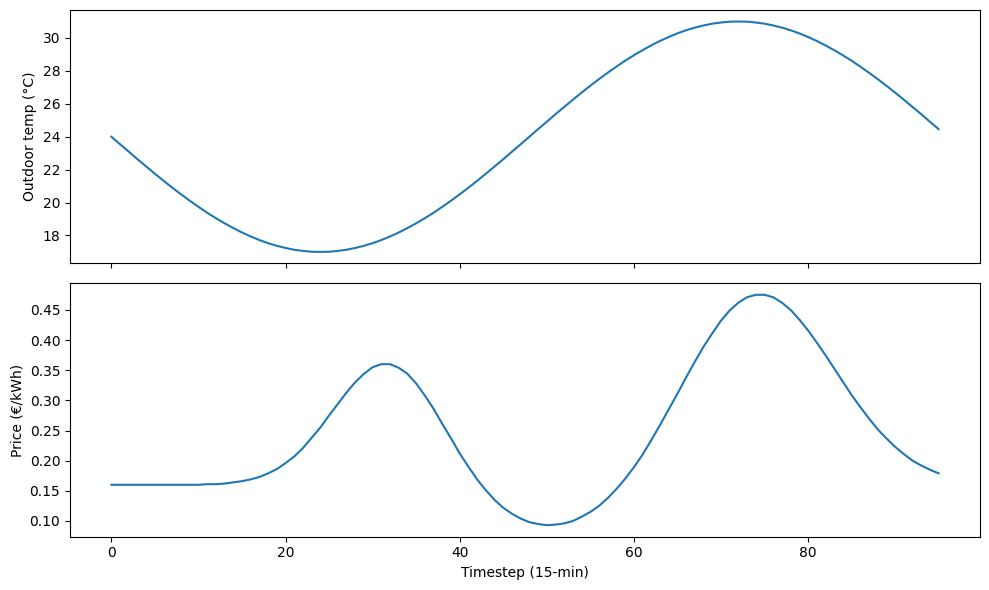

In [ ]:
# --- Enhanced Plot ---
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(hours, df["t_out_c"], label="Outdoor Temp (°C)", color='tab:red')
ax[0].plot(hours, df["comfort_setpoint_c"], 'k--', label="Comfort Setpoint (°C)")
ax[0].fill_between(hours, comfort_band[0], comfort_band[1], 
                   where=df["in_work_hours"]==1, color='orange', alpha=0.1, label="Comfort Band")
ax[0].set_ylabel("Temperature (°C)")
ax[0].legend(loc="upper right")

ax[1].plot(hours, df["price_eur_per_kwh"], label="Electricity Price", color='tab:blue')
ax[1].set_ylabel("Price (€/kWh)")
ax[1].legend(loc="upper right")

ax[2].plot(hours, df["solar_gen_kw_per_kwp"], label="Solar Gen (kW/kWp)", color='tab:green')
ax[2].set_ylabel("Solar Gen")
ax[2].set_xlabel("Hour of Day")
ax[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [40]:

# --- Save CSV ---
df.to_csv(out_csv, index=False)
print(f"Saved → {out_csv}  (rows={len(df)})")
df.head(10)


Saved → day01_prices_weather.csv  (rows=96)


,t,dt_h,t_out_c,price_eur_per_kwh
0,0,0.25,24.00,0.16
1,1,0.25,23.54,0.16
2,2,0.25,23.09,0.16
3,3,0.25,22.63,0.16
4,4,0.25,22.19,0.16
5,5,0.25,21.75,0.16
6,6,0.25,21.32,0.16
7,7,0.25,20.90,0.16
8,8,0.25,20.50,0.16
9,9,0.25,20.11,0.16


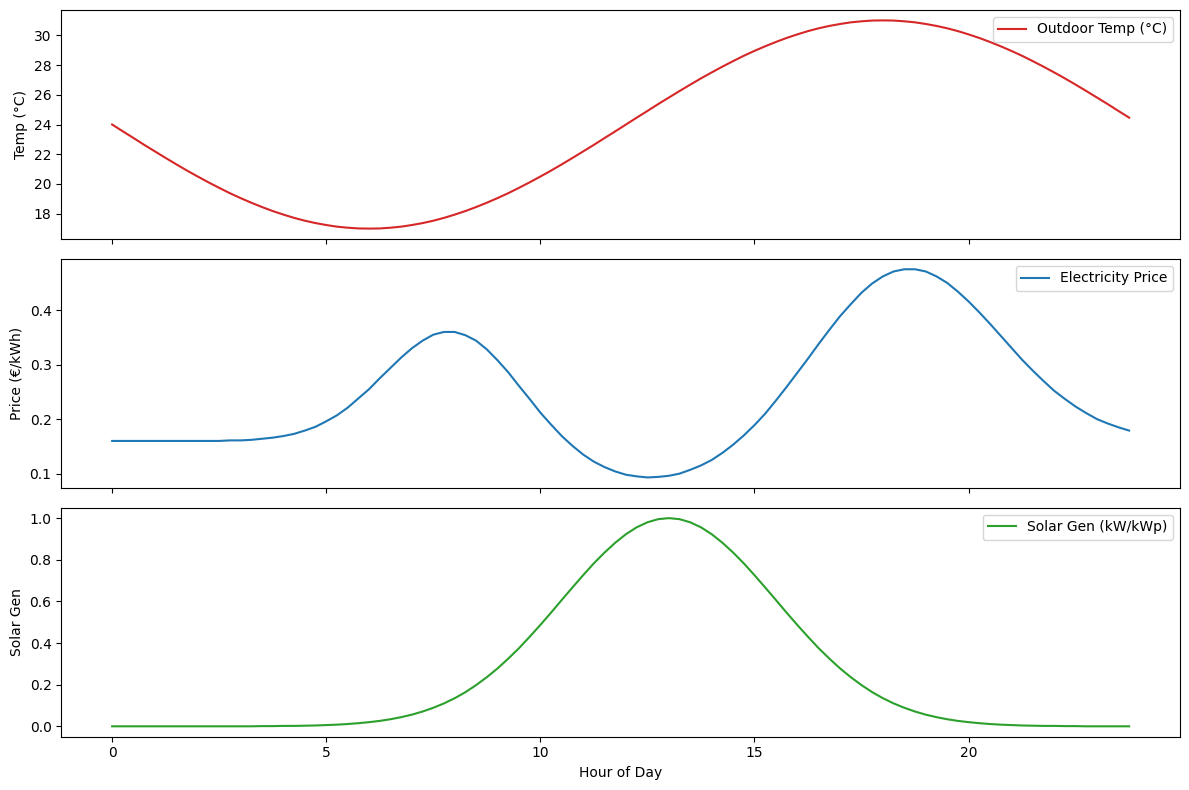

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
dt_h = 0.25                     # hours per step (15 min)
T = int(24 / dt_h)             # steps per day

# Outdoor temperature profile (hot day)
t_mean = 24.0
t_amp = 7.0
t_warmest_hour = 12

# Duck curve price profile
base_price = 0.16
morning_peak_eur = 0.22
evening_peak_eur = 0.33
midday_valley_eur = 0.08

sigma_morning_h = 1.6
sigma_evening_h = 2.2
sigma_midday_h = 3.0

# Solar generation
solar_peak_hour = 13.0
solar_sigma_h = 2.5
solar_max = 1.0

# Work hours — NOW these are the hours we DO NOT care about comfort
work_start, work_end = 9.0, 17.0

# Optional jitter
temp_jitter_std = 0.0
price_jitter_std = 0.0

# Output file
out_csv = "day01_prices_weather.csv"

# --- Time Vectors ---
t = np.arange(T)
hours = t * dt_h

# --- Gaussian function ---
def gauss(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

# --- Outdoor Temperature ---
t_out = t_mean + t_amp * np.sin(2 * np.pi * (hours - t_warmest_hour) / 24.0)
if temp_jitter_std > 0:
    t_out += np.random.default_rng(0).normal(0, temp_jitter_std, size=T)

# --- Price Profile ---
price = (base_price
         + morning_peak_eur * gauss(hours, 8.0, sigma_morning_h)
         + evening_peak_eur * gauss(hours, 18.5, sigma_evening_h)
         - midday_valley_eur * gauss(hours, 13.0, sigma_midday_h))

if price_jitter_std > 0:
    price += np.random.default_rng(1).normal(0, price_jitter_std, size=T)

price = np.clip(price, 0.05, None)

# --- Solar Generation ---
solar_gen = solar_max * gauss(hours, solar_peak_hour, solar_sigma_h)

# --- In-Comfort Hours (inverse of work hours: when we DO care) ---
in_comfort_hours = (hours < work_start) | (hours > work_end)

# --- Create DataFrame ---
df = pd.DataFrame({
    "t": t.astype(int),
    "dt_h": np.full(T, dt_h),
    "hour_of_day": hours,
    "t_out_c": np.round(t_out, 2),
    "price_eur_per_kwh": np.round(price, 3),
    "solar_gen_kw_per_kwp": np.round(solar_gen, 3),
    "in_work_hours": (~in_comfort_hours).astype(int)  # 1 = at work (we don't care about comfort)
})

# --- Save to CSV ---
df.to_csv(out_csv, index=False)

# --- Plotting ---
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Outdoor temperature
ax[0].plot(df["hour_of_day"], df["t_out_c"], label="Outdoor Temp (°C)", color='tab:red')
ax[0].set_ylabel("Temp (°C)")
ax[0].legend(loc="upper right")

# Price
ax[1].plot(df["hour_of_day"], df["price_eur_per_kwh"], label="Electricity Price", color='tab:blue')
ax[1].set_ylabel("Price (€/kWh)")
ax[1].legend(loc="upper right")

# Solar generation
ax[2].plot(df["hour_of_day"], df["solar_gen_kw_per_kwp"], label="Solar Gen (kW/kWp)", color='tab:green')
ax[2].set_ylabel("Solar Gen")
ax[2].set_xlabel("Hour of Day")
ax[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


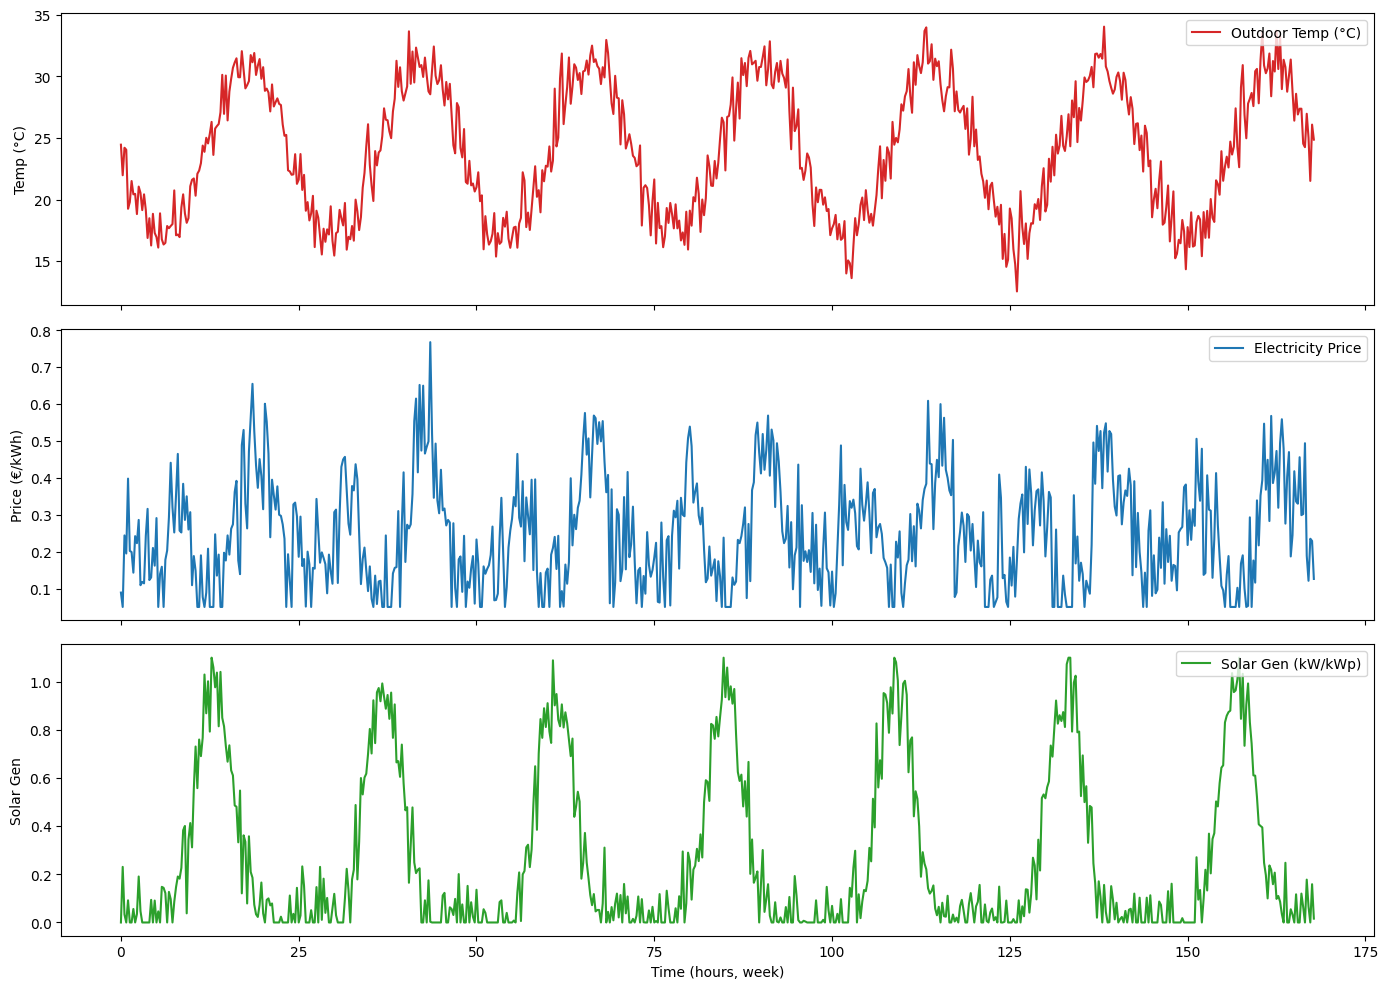

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
dt_h = 0.25                     # hours per step (15 min)
T_day = int(24 / dt_h)          # steps per day
days = 7                        # simulate a week
T = T_day * days                # total steps

# Outdoor temperature profile (hot day)
t_mean = 24.0
t_amp = 7.0
t_warmest_hour = 12

# Duck curve price profile
base_price = 0.16
morning_peak_eur = 0.22
evening_peak_eur = 0.33
midday_valley_eur = 0.08

sigma_morning_h = 1.6
sigma_evening_h = 2.2
sigma_midday_h = 3.0

# Solar generation
solar_peak_hour = 13.0
solar_sigma_h = 2.5
solar_max = 1.0

# Work hours (comfort ignored)
work_start, work_end = 9.0, 17.0

# Noise standard deviations
temp_jitter_std = 1.5        # °C
price_jitter_std = 0.1      # €/kWh
solar_jitter_std = 0.1      # kW/kWp

# Output file
out_csv = "week01_prices_weather.csv"

# --- Time Vectors ---
t = np.arange(T)
hours_total = t * dt_h
hour_of_day = hours_total % 24
day_index = (hours_total // 24).astype(int) + 1  # day counter 1–7

# --- Gaussian function ---
def gauss(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

# --- Initialize RNG for reproducibility ---
rng = np.random.default_rng(42)

# --- Outdoor Temperature ---
t_out = t_mean + t_amp * np.sin(2 * np.pi * (hour_of_day - t_warmest_hour) / 24.0)
t_out += rng.normal(0, temp_jitter_std, size=T)

# --- Price Profile ---
price = (base_price
         + morning_peak_eur * gauss(hour_of_day, 8.0, sigma_morning_h)
         + evening_peak_eur * gauss(hour_of_day, 18.5, sigma_evening_h)
         - midday_valley_eur * gauss(hour_of_day, 13.0, sigma_midday_h))
price += rng.normal(0, price_jitter_std, size=T)
price = np.clip(price, 0.05, None)

# --- Solar Generation ---
solar_gen = solar_max * gauss(hour_of_day, solar_peak_hour, solar_sigma_h)
solar_gen += rng.normal(0, solar_jitter_std, size=T)
solar_gen = np.clip(solar_gen, 0.0, 1.1)

# --- In-Comfort Hours (inverse of work hours) ---
in_comfort_hours = (hour_of_day < work_start) | (hour_of_day > work_end)

# --- Create DataFrame ---
df = pd.DataFrame({
    "t": t.astype(int),
    "day": day_index,
    "dt_h": np.full(T, dt_h),
    "hour_of_day": hour_of_day,
    "t_out_c": np.round(t_out, 2),
    "price_eur_per_kwh": np.round(price, 3),
    "solar_gen_kw_per_kwp": np.round(solar_gen, 3),
    "in_work_hours": (~in_comfort_hours).astype(int)  # 1 = at work (don’t care about comfort)
})

# --- Save to CSV ---
df.to_csv(out_csv, index=False)

# --- Plotting ---
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Outdoor temperature
ax[0].plot(df["t"] * dt_h, df["t_out_c"], label="Outdoor Temp (°C)", color='tab:red')
ax[0].set_ylabel("Temp (°C)")
ax[0].legend(loc="upper right")

# Price
ax[1].plot(df["t"] * dt_h, df["price_eur_per_kwh"], label="Electricity Price", color='tab:blue')
ax[1].set_ylabel("Price (€/kWh)")
ax[1].legend(loc="upper right")

# Solar generation
ax[2].plot(df["t"] * dt_h, df["solar_gen_kw_per_kwp"], label="Solar Gen (kW/kWp)", color='tab:green')
ax[2].set_ylabel("Solar Gen")
ax[2].set_xlabel("Time (hours, week)")
ax[2].legend(loc="upper right")

plt.tight_layout()
plt.show()
